To see which features are important, we will use weather data only from the San Diego Lindbergh Field weather station, which is assigned to the highest number of incidents and is at a central location, and all incident data. 

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time

# Package to calculate distance between two coordinates
import geopy.distance

# Import supplementary visualization code visuals.py
import visuals as vs


# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore")

# Import libraries for data visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

# Pretty display for notebooks
%matplotlib inline

In [2]:
# Load the location data of all weather stations analyzed
stations_analyzed=pd.read_csv('stations_analyzed.csv', header=0,index_col=0)
stations_analyzed

,stations,abbreviations,latitude,longitude
12,san_diego_lindbergh_field,KSAN,32.73361,-117.18306
14,san_diego_montgomery_field,KMYF,32.81444,-117.13639
13,san_diego_brown_field,KSDM,32.57528,-116.99306
11,ramona,KRNM,33.03750,-116.91583
0,carlsbad,KCRQ,33.12680,-117.27583


In [3]:
# Load the engineered weather station data for the San Diego Lindbergh Field Station
sdlf=pd.read_csv('san_diego_lindbergh_field_engineered.csv',header=0,parse_dates=True)
sdlf.head()

,date,high_low_diff,high_temp_diff,high_temp_alert,rain_alert,observed_precipitation,observed_low,observed_high
0,2016-09-01,8,NaN,0,0,0.0,64,72
1,2016-09-02,10,1.0,0,0,0.0,63,73
2,2016-09-03,6,-3.0,0,0,0.0,64,70
3,2016-09-04,9,4.0,0,0,0.0,65,74
4,2016-09-05,7,-2.0,0,0,0.0,65,72


In [4]:
# Load the data for all incidents
parse_dates = ['Response_Date']
incidents_sd=pd.read_csv('incidents_sd.csv',header=0,parse_dates=parse_dates)

In [5]:
# Create a column which contains only the date of the incident, not time of day 
incidents_sd['Response_Day'] = incidents_sd['Response_Date'].dt.date

# Group incidents by the date of the incident and get the number of incidents for each day
incidents_grouped=incidents_sd.groupby('Response_Day',as_index=False)['ID'].count()

In [6]:
# Just keep the columns with weather data in them as an input to the model
sdlf_input=sdlf.iloc[:,1:]
sdlf_input.head()

,high_low_diff,high_temp_diff,high_temp_alert,rain_alert,observed_precipitation,observed_low,observed_high
0,8,NaN,0,0,0.0,64,72
1,10,1.0,0,0,0.0,63,73
2,6,-3.0,0,0,0.0,64,70
3,9,4.0,0,0,0.0,65,74
4,7,-2.0,0,0,0.0,65,72


In [7]:
# Create a dataframe with the number of incidents up to 7 days ago and all weather-related features
series=incidents_grouped['ID']
df_lags = pd.DataFrame()
for i in range(7,0,-1):
    df_lags['t-'+str(i)] = series.shift(i)
df_lags['t'] = series.values
input_output=pd.concat([sdlf_input, df_lags], axis=1)
# Remove the first 7 rows of the data which contain nan values
input_output = input_output.iloc[7:]
print(input_output.head())
# Save to new file
input_output.to_csv('all_features_7_time_lags.csv', index=False)

    high_low_diff  high_temp_diff  high_temp_alert  rain_alert  \
7               8             3.0                0           0   
8               9             1.0                0           0   
9               8            -2.0                0           0   
10              9             0.0                0           0   
11              5            -5.0                0           0   

    observed_precipitation  observed_low  observed_high    t-7    t-6    t-5  \
7                      0.0            68             76  363.0  412.0  376.0   
8                      0.0            68             77  412.0  376.0  399.0   
9                      0.0            67             75  376.0  399.0  366.0   
10                     0.0            66             75  399.0  366.0  364.0   
11                     0.0            65             70  366.0  364.0  356.0   

      t-4    t-3    t-2    t-1    t  
7   399.0  366.0  364.0  356.0  385  
8   366.0  364.0  356.0  385.0  392  
9   364.

In [8]:
# Draw a heatmap of correlations among all numeric features
def correlation_matrix(dataset):
    numeric_columns=dataset.select_dtypes(include=['int','float']).columns.values.tolist()
    fig, ax = plt.subplots(figsize=(11,10))     
    sns.heatmap(dataset[numeric_columns].corr(),cmap='viridis_r', annot=True, ax=ax)
    fig.tight_layout()
    fig.show() 

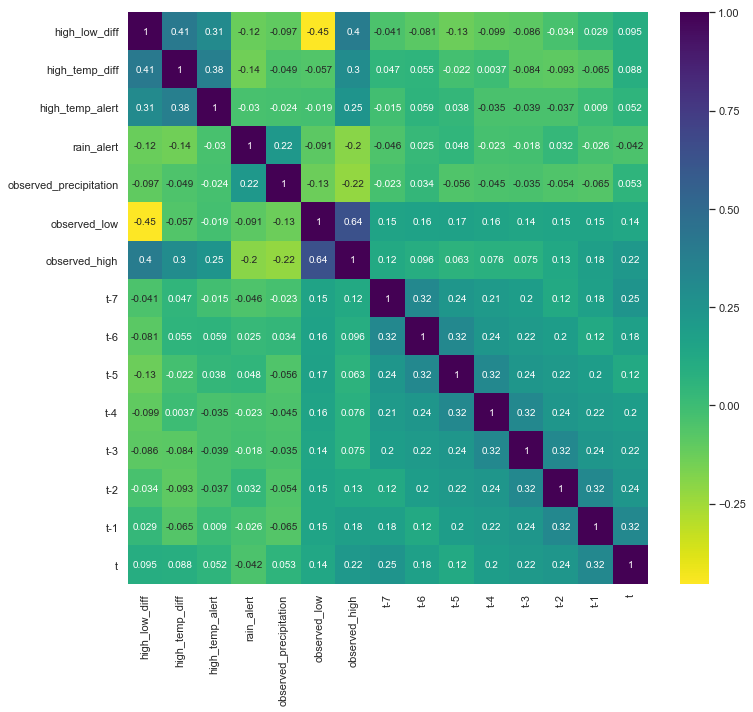

In [9]:
# Draw the correlation matrix with seven days of number of incidents and all weather-related features
correlation_matrix(input_output)

Among the weather-related feature, "observed_high", which is the observed highest temperature during the day seems to be correlated with "t" the most, which the number of incidents on the same day. However, it is important to note that there are strong correlations among the weather-related features as well. Therefore, we will not yet dismiss the other weather-related features.

In [10]:
# Define a function to calculate the feature importances of features given a model and feature importances of that model
def feature_plot(model, importances, X, num_features):
    # Display the features in the order of importance
    indices = np.argsort(importances)[:num_features]
    columns = X.columns.values[indices[:]]
    values = importances[indices][:]

    # Define the colors for the plot
    base_color1 = sns.color_palette()[0]

    # Create the plot
    fig = plt.figure(figsize = (8,6))
    plt.title("Feature Importances ({})".format(model.__class__.__name__), fontsize = 16)
    plt.barh(np.arange(num_features), values, align="center", color = base_color1)
    plt.yticks(np.arange(num_features), columns, fontsize = 14)
    plt.xlabel("Normalized Weight", fontsize = 14, fontweight='bold')
    plt.ylabel("Features", fontsize = 14, fontweight='bold')
    #ax.set_yticklabels({'t-1':'# of calls one day ago','t-2':'# of calls two days ago','t-3':'# of calls three days ago','t-4':'# of calls four days ago', 't-5':'# of calls five days ago','t-6':'# of calls six days ago','t-7':'# of calls one week ago',\
    #                'observed_high':'highest temperature','observed_low':'lowest temperature'})
    plt.tight_layout()
    plt.show()  

In [11]:
# Show the columns of the input_output dataframe
input_output.columns

Index(['high_low_diff', 'high_temp_diff', 'high_temp_alert', 'rain_alert',
       'observed_precipitation', 'observed_low', 'observed_high', 't-7', 't-6',
       't-5', 't-4', 't-3', 't-2', 't-1', 't'],
      dtype='object')

1) We will first find the feature importances for all available features:

[19:07:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


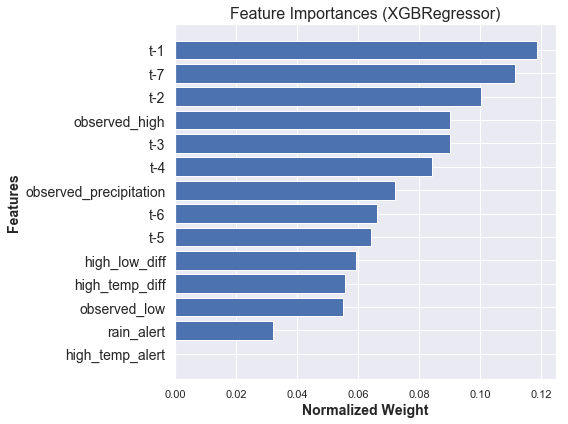

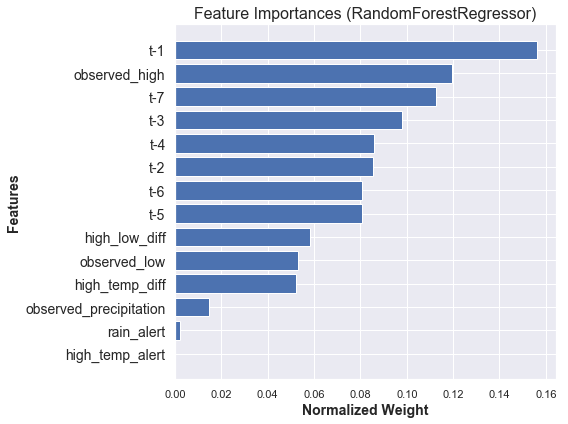

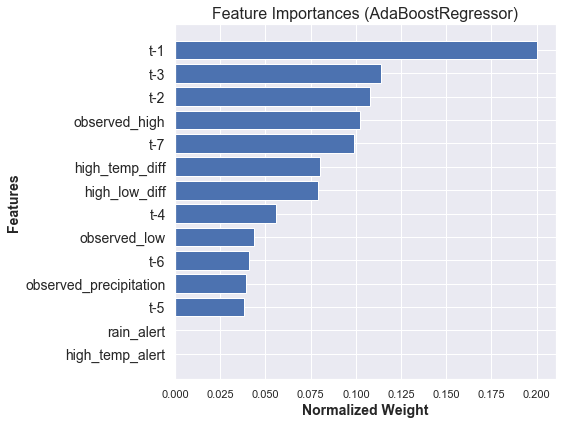

In [12]:
# Run RandomForestRegressor, XGBoostRegressor and AdaboostRegressor
# and use the feature importance methods of these models to rank the features

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor

# Split the input_output dataframe into features (weather-related features and time lags t-1 thorugh t-7) and target (t)
X = input_output.iloc[:,0:-1]
y = input_output.iloc[:,-1]

# Train the supervised models 
model1 = xgb.XGBRegressor(random_state=0)
model1.fit(X, y)
model2=RandomForestRegressor(random_state=0)
model2.fit(X, y)
model3=AdaBoostRegressor(random_state=0)
model3.fit(X, y)

for model in [model1, model2, model3]:
    # Extract the feature importances using .feature_importances_ 
    importances = model.feature_importances_ 
    # Plot feature importances for all features
    feature_plot(model, importances, X, num_features=X.shape[1])

Note that "observed_high", highest temperature during the day, is ranked as the most important feature among all weather-related features in all three models. However, this doesn't necessarily mean that other weather-related features are not important. As we have seen in the Pearson correlation matrix above, the "observed_high" and "observed_low" temperatures are highly correlated with each other and show the highest correlation among all weather-related feautures with the target variable "t". Therefore, we are going to remove first "observed_high" from the feature set and run the feature importances again to see if "observed_low" will rank as highly as "observed_high".

2) Find the feature importances for all features except "observed_high":

[17:33:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


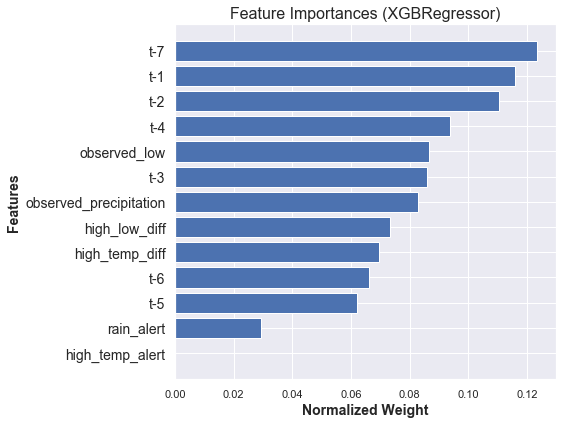

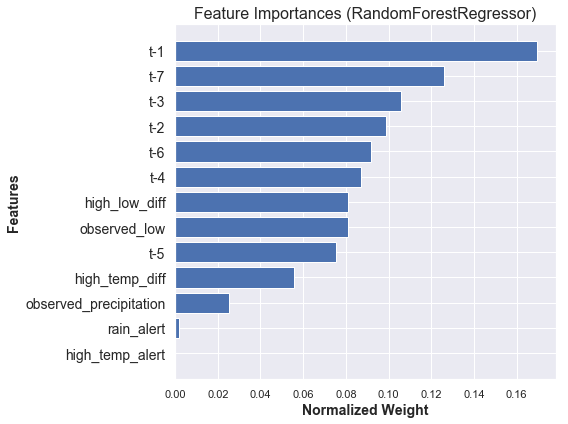

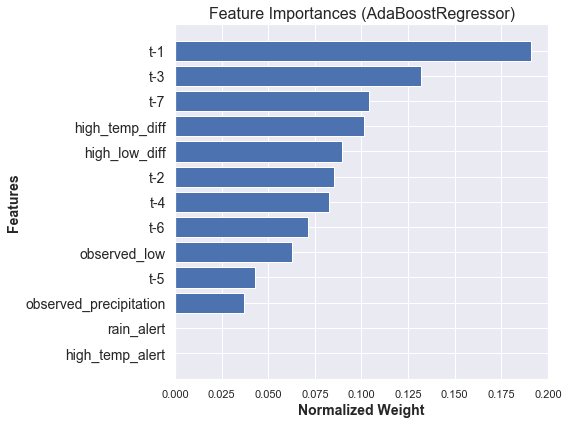

In [13]:
# Run RandomForestRegressor, XGBoostRegressor and AdaboostRegressor
# and use the feature importance methods of these models to rank the features

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor

# Split the input_output dataframe into features (weather-related features and time lags t-1 thorugh t-7) and target (t)
X = input_output.iloc[:,[0,1,2,3,4,5,7,8,9,10,11,12,13]]
y = input_output.iloc[:,-1]

# Train the supervised models 
model1 = xgb.XGBRegressor(random_state=0)
model1.fit(X, y)
model2=RandomForestRegressor(random_state=0)
model2.fit(X, y)
model3=AdaBoostRegressor(random_state=0)
model3.fit(X, y)

for model in [model1, model2, model3]:
    # Extract the feature importances using .feature_importances_ 
    importances = model.feature_importances_ 
    # Plot feature importances for all features
    feature_plot(model, importances, X, num_features=X.shape[1])

Comparing the above set of feature importances to the ones with all features, we see that no other weather-related feature exceeds the ranking of "observed_high" in all three models. Finally, let's remove both "observed_high" and "observed_low" from the feature set and see if other weather-related features can rank as high as these two features:

3) Find the feature importances for all features except "observed_high" and "observed_low":

[17:33:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


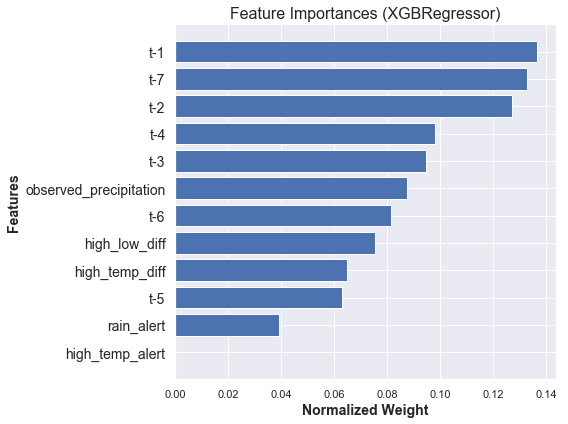

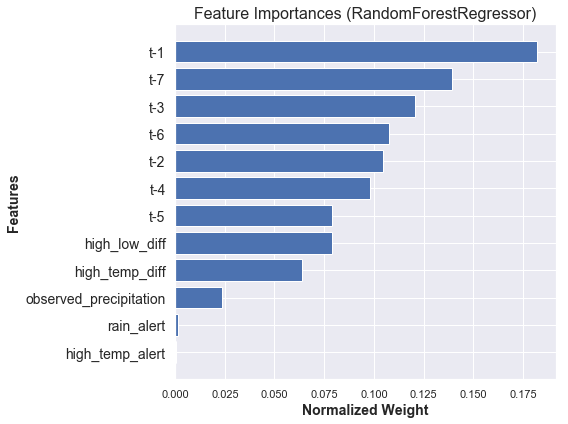

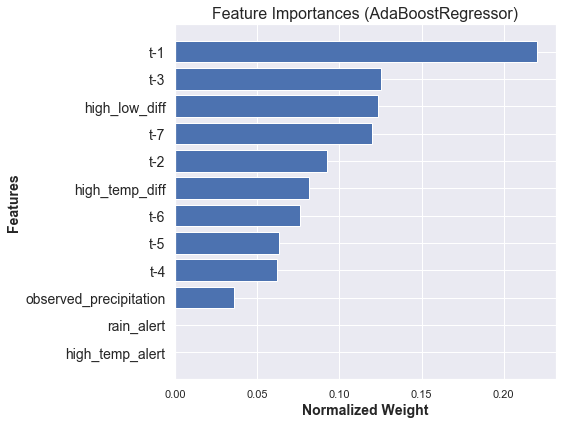

In [14]:
# Run RandomForestRegressor, XGBoostRegressor and AdaboostRegressor
# and use the feature importance methods of these models to rank the features

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor

# Split the input_output dataframe into features (weather-related features and time lags t-1 thorugh t-7) and target (t)
X = input_output.iloc[:,[0,1,2,3,4,7,8,9,10,11,12,13]]
y = input_output.iloc[:,-1]

# Train the supervised models 
model1 = xgb.XGBRegressor(random_state=0)
model1.fit(X, y)
model2=RandomForestRegressor(random_state=0)
model2.fit(X, y)
model3=AdaBoostRegressor(random_state=0)
model3.fit(X, y)

for model in [model1, model2, model3]:
    # Extract the feature importances using .feature_importances_ 
    importances = model.feature_importances_ 
    # Plot feature importances for all features
    feature_plot(model, importances, X, num_features=X.shape[1])

Only the "high_low_diff" can rank as highly as "observed_high" and only in the Adaboost model. Given that it is defined as "observed_high" minus "observed_low", this ranking makes sense. Given the results above and that one important weather-related feature, if any, will be used for the multi-variate time series forecasting model, we decide to include the "observed_high" temperature.